In [1]:
import h5py
import random
import numpy as np
import tensorflow as tf
from datetime import datetime
#import H5pyHelper
from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50 
from tensorflow.keras.applications.inception_v3 import InceptionV3
#import dask.array as da
#from dask.array.slicing import shuffle_slice
import cv2
import pandas as pd
import os
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

2022-07-17 18:48:16.953037: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-17 18:48:16.953055: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
BATCH_SIZE = 32


Num GPUs Available:  0


2022-07-17 18:48:18.411116: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.10/site-packages/cv2/../../lib64:
2022-07-17 18:48:18.411132: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-17 18:48:18.411148: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Sergio-Ubuntu): /proc/driver/nvidia/version does not exist


In [3]:
df = pd.read_csv("data_cleaning/clean_data/image_paths.csv")

## get all unique labels and sort them (for classification_report)
inps = list(df['label'].unique())
inps.sort()
print(inps)
print(df)

# shuffle dataframe
df = df.sample(frac=1)


# stratify ensures that train validate and test sets have approximately the same percentage of samples of each target class as the complete set
# more info here: https://stats.stackexchange.com/questions/250273/benefits-of-stratified-vs-random-sampling-for-generating-training-data-in-classi
# this is good because we have some data that is not evenly represented in the dataset which leads to poor performance if not evenly distributed in training/validating/testing
train,test = train_test_split(df, test_size=0.1, random_state=1,stratify=df['label'])
train,validate = train_test_split(train, test_size=0.111, random_state=1,stratify=train['label']) # 0.25 x 0.8 = 0.2

image_datagen = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True,
    horizontal_flip=True,
    rescale= 1.0/255.0,
    rotation_range=30
    )

test_image_datagen = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True,
    rescale= 1.0/255.0,
    )

train_iterator = image_datagen.flow_from_dataframe(train,x_col="image-path",y_col="label",batch_size=BATCH_SIZE,target_size=(256,256),classes=inps,class_mode="categorical", shuffle=True)

batch_x,batch_y = train_iterator.next()
NUM_CLASSES = batch_y.shape[1]

validate_iterator = image_datagen.flow_from_dataframe(validate,x_col="image-path",y_col="label",batch_size=BATCH_SIZE, target_size=(256,256),classes=inps,class_mode="categorical", shuffle=True)

test_iterator = test_image_datagen.flow_from_dataframe(test,x_col="image-path",y_col="label",batch_size=BATCH_SIZE, target_size=(256,256),classes=inps,class_mode="categorical")

['Abronia elliptica']
                                            image-path              label
0    data_cleaning/clean_data/Abronia elliptica/efd...  Abronia elliptica
1    data_cleaning/clean_data/Abronia elliptica/d7c...  Abronia elliptica
2    data_cleaning/clean_data/Abronia elliptica/7ce...  Abronia elliptica
3    data_cleaning/clean_data/Abronia elliptica/ba8...  Abronia elliptica
4    data_cleaning/clean_data/Abronia elliptica/d44...  Abronia elliptica
..                                                 ...                ...
195  data_cleaning/clean_data/Abronia elliptica/aff...  Abronia elliptica
196  data_cleaning/clean_data/Abronia elliptica/8da...  Abronia elliptica
197  data_cleaning/clean_data/Abronia elliptica/310...  Abronia elliptica
198  data_cleaning/clean_data/Abronia elliptica/884...  Abronia elliptica
199  data_cleaning/clean_data/Abronia elliptica/2c7...  Abronia elliptica

[200 rows x 2 columns]
Found 160 validated image filenames belonging to 1 classes.
Found 

In [7]:
## modified code from https://towardsdatascience.com/3-things-you-need-to-know-before-you-train-test-split-869dfabb7e50
def get_class_counts(df):
    grp = df.groupby(['label']).nunique()

    return grp.to_dict()['image-path']
def get_class_proportions(df):
    class_counts = get_class_counts(df)
    return {val[0]: round(val[1]/df.shape[0],4) for val in class_counts.items()}

print(get_class_counts(test)['Abronia elliptica'])

20


In [8]:
## alex net
#model = models.Sequential([
#    layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(256,256,3)),
#    layers.BatchNormalization(),
#    layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
#    layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
#    layers.BatchNormalization(),
#    layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
#    layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
#    layers.BatchNormalization(),
#    layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
#    layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same", kernel_regularizer=tf.keras.regularizers.l2(l=0.04)),
#    layers.BatchNormalization(),
#    layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
#    layers.BatchNormalization(),
#    layers.Flatten(),
#    #layers.Dense(1024, activation='relu'),
#    #layers.Dropout(0.5),
#    layers.Dense(1024, activation='relu'),
#    layers.Dropout(0.7),
#    layers.Dense(NUM_CLASSES, activation='softmax')
#])

# we do not want the default output layer
#model = VGG16(include_top=False, input_shape=(256,256,3))
#model = InceptionV3(include_top=False, input_shape=(256,256,3), weights='imagenet')
model = ResNet50(include_top=False, input_shape=(256,256,3))

#for layer in model.layers:
    #layer.trainable = False

# mark some layers as not trainable
#model.get_layer('block1_conv1').trainable = False
#model.get_layer('block1_conv2').trainable = False
#model.get_layer('block2_conv1').trainable = False
#model.get_layer('block2_conv2').trainable = False
flat1 = layers.Flatten()(model.output)

#layers.Dense(1024, activation='relu'),
#layers.Dropout(0.5),
class1 = layers.Dense(1024, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l=0.04))(flat1)
layers.Dropout(0.7),
output = layers.Dense(NUM_CLASSES, activation='softmax')(class1)

model = tf.keras.Model(inputs=model.inputs, outputs = output)

model.summary()

2022-07-17 18:49:52.453334: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


94765736/94765736 [==============================] - 2s 0us/step


2022-07-17 18:49:56.088233: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 536870912 exceeds 10% of free system memory.
2022-07-17 18:49:56.181880: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 536870912 exceeds 10% of free system memory.
2022-07-17 18:49:56.231427: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 536870912 exceeds 10% of free system memory.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [9]:
model.compile(loss='categorical_crossentropy', optimizer=tf.optimizers.SGD(learning_rate=0.0001), metrics=['accuracy'])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
fit = model.fit(x=train_iterator,
                steps_per_epoch= len(train_iterator),
                #callbacks=[callback], 
                validation_steps= len(validate_iterator),
                validation_data=validate_iterator,
                verbose=1,
                epochs=50)

Epoch 1/50


2022-07-17 18:50:07.812388: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 536870912 exceeds 10% of free system memory.
2022-07-17 18:50:07.991250: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 536870912 exceeds 10% of free system memory.


In [ ]:
# get all test labels from dataframe
y_true = []

# get all true labels
for i in range(len(test_iterator)):
    batch_x,batch_y = test_iterator.next()
    batch_y = list(batch_y)
    y_true += batch_y

#print(y_true)
# get test predictions
y_pred = model.predict(x = test_iterator,
                    steps = len(test_iterator),
                    batch_size=BATCH_SIZE,
                    verbose=1)

# convert one hot to max index
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_true, axis=1)

print(accuracy_score(y_true,y_pred) * 100, "%")

# have to include labels parameter because test set does not have all of the classes from inps
matrix = classification_report(y_true,y_pred,labels=np.arange(len(inps)),target_names =inps)
print('Classification report: \n',matrix)




45/45 [==============================] - 4s 68ms/step
1.4716187806587244 %
Classification report: 
                            precision    recall  f1-score   support

        Abronia elliptica       0.00      0.00      0.00        20
         Abronia fragrans       0.00      0.00      0.00        20
             Abronia nana       0.00      0.00      0.00         6
     Achillea millefolium       0.00      0.00      0.00        20
     Aconitum columbianum       0.05      0.10      0.07        20
             Actaea rubra       0.00      0.00      0.00        20
    Agastache urticifolia       0.08      0.05      0.06        20
      Agoseris aurantiaca       0.00      0.00      0.00        20
          Agoseris glauca       0.00      0.00      0.00        20
    Aliciella pinnatifida       0.00      0.00      0.00         8
          Alisma triviale       0.00      0.00      0.00        20
       Allionia incarnata       0.00      0.00      0.00        20
        Allium acuminatum   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model.save('model/')

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model('model/') # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: model/assets


/usr/local/lib/python3.6/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


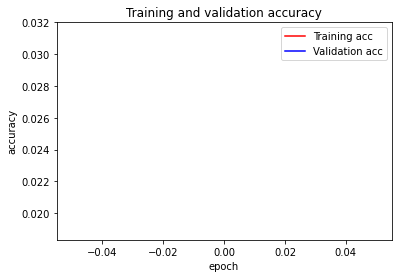

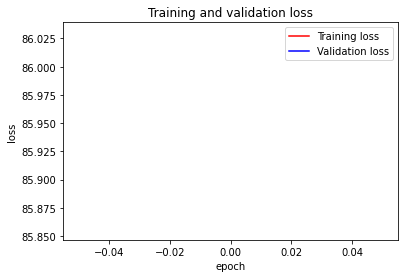

In [ ]:
import matplotlib.pyplot as plt 
#Graphing our training and validation
acc = fit.history['accuracy']
val_acc = fit.history['val_accuracy']
loss = fit.history['loss']
val_loss = fit.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()
plt.show()

Normalized confusion matrix


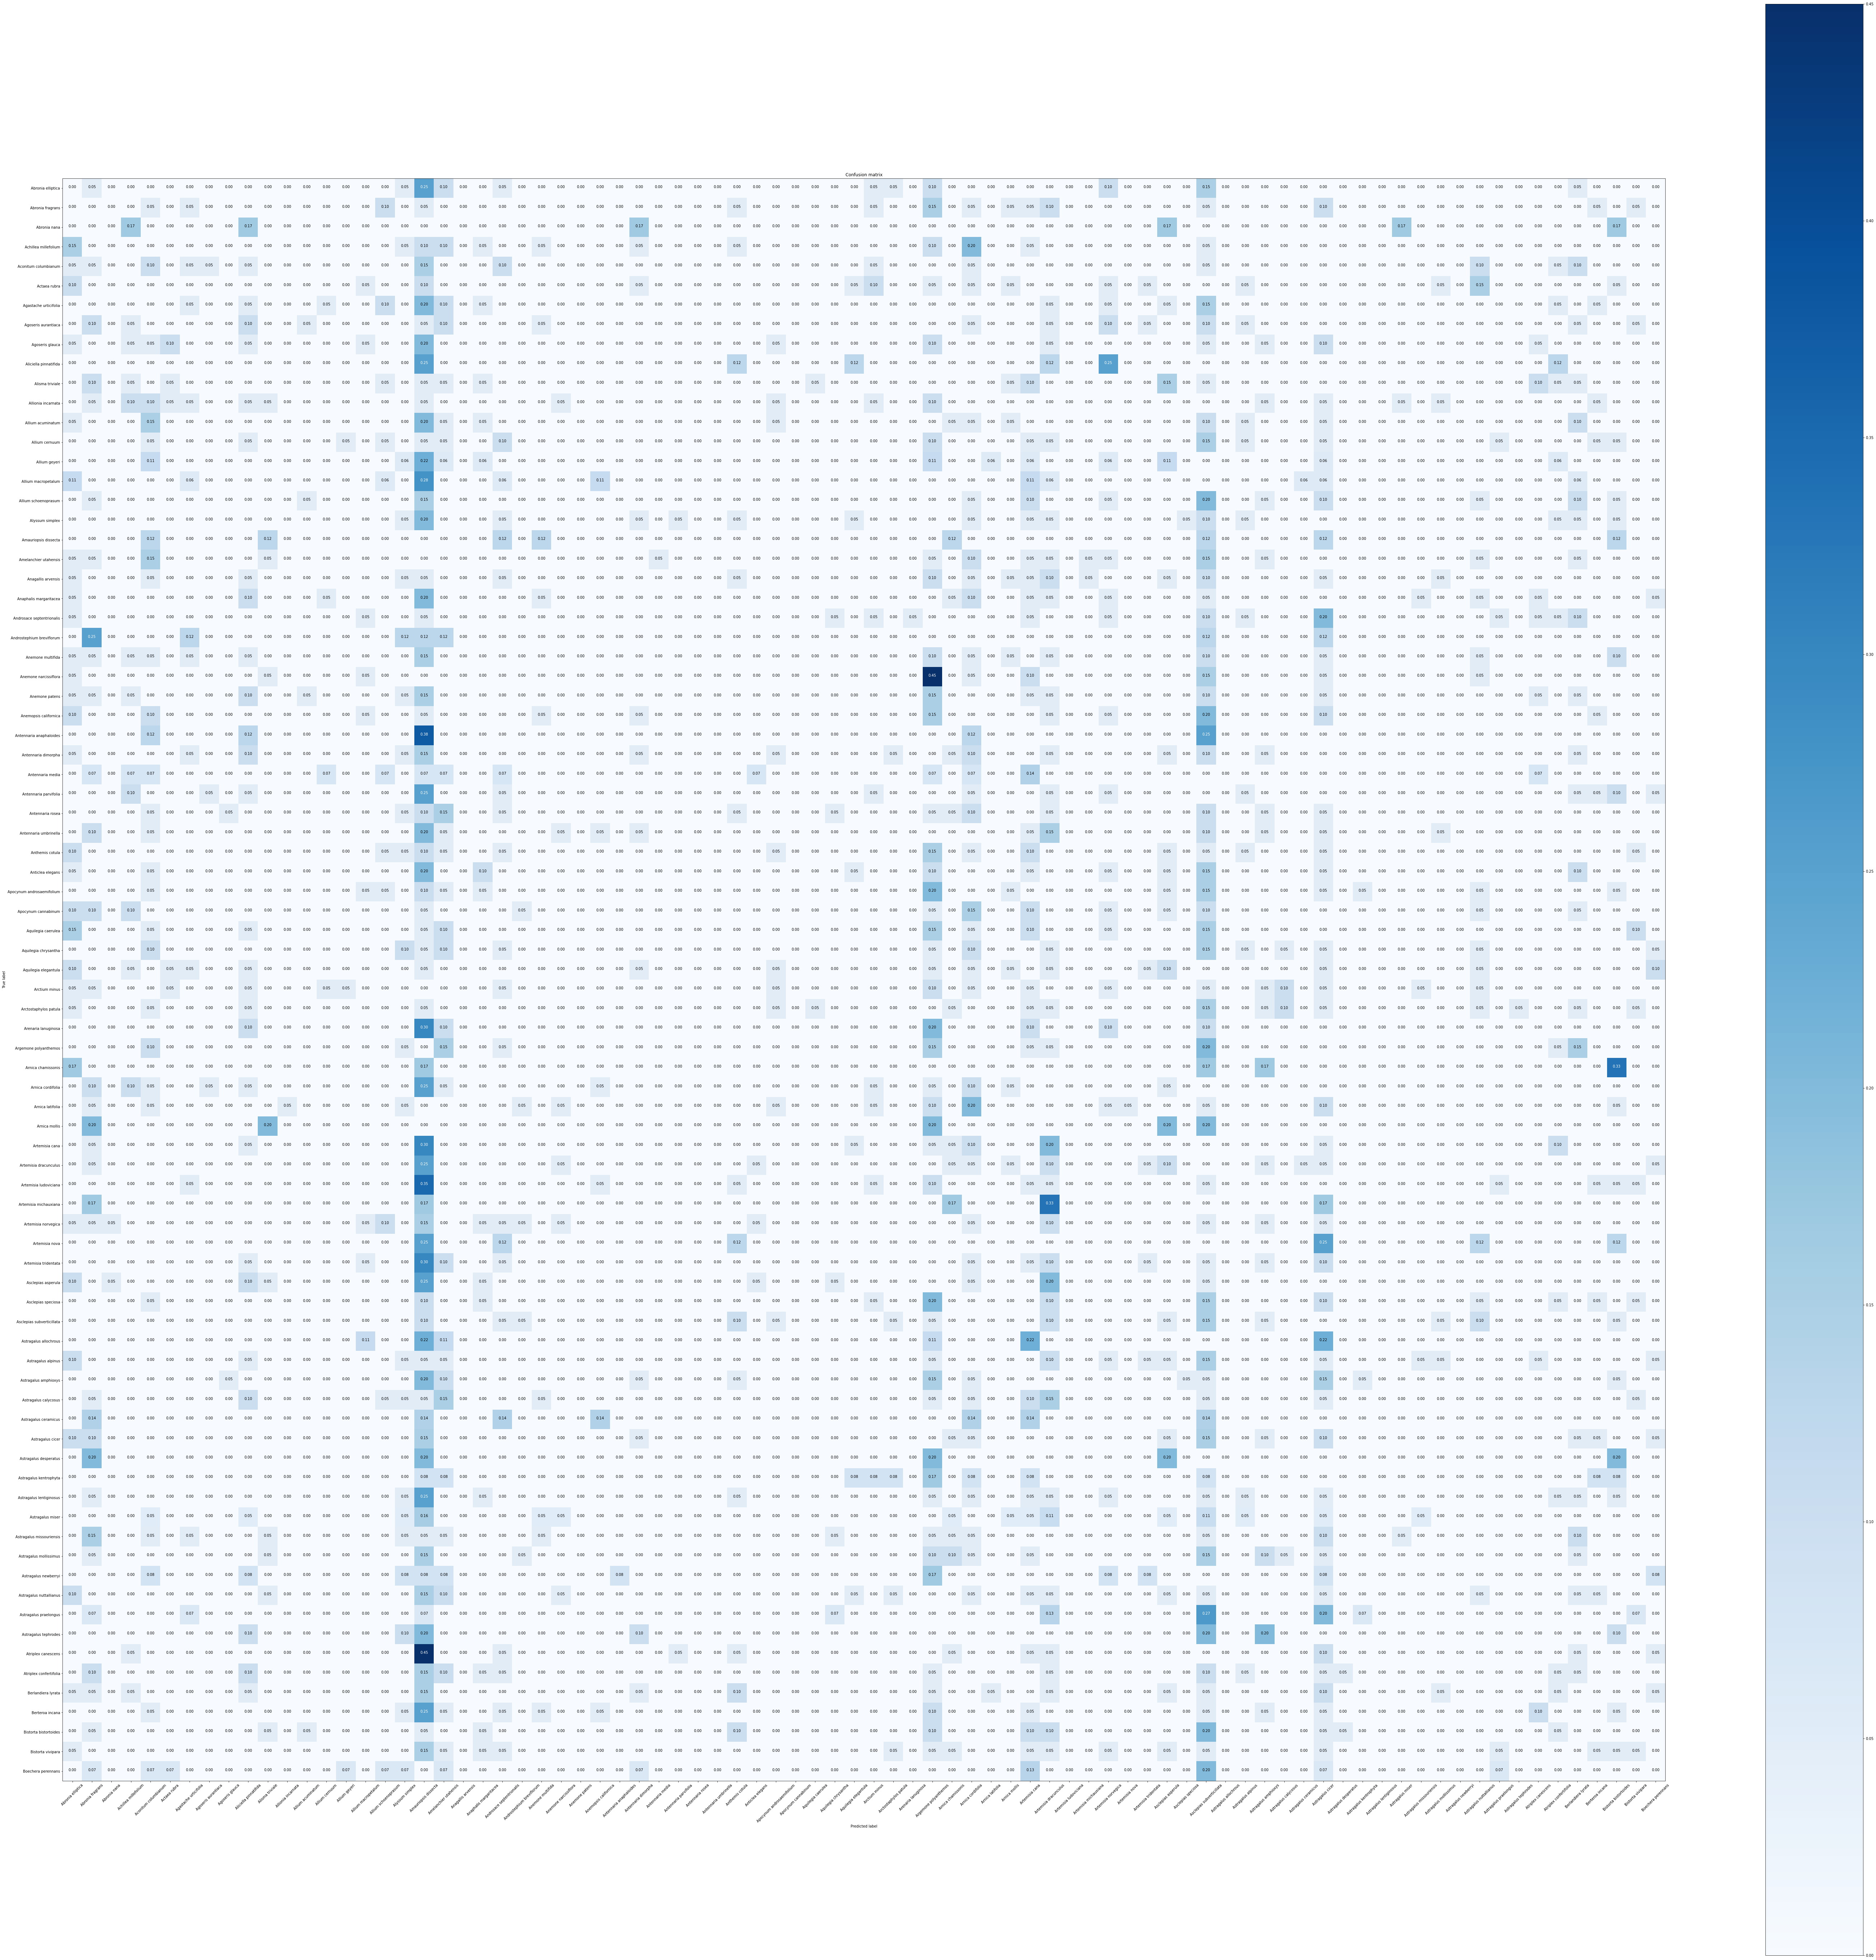

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

# grabbed from here: https://towardsdatascience.com/a-simple-cnn-multi-image-classifier-31c463324fa
confusion_matrix = confusion_matrix(y_true,y_pred)

def plot_confusion_matrix(cm, classes,
   normalize=False,
   title='Confusion matrix',
   cmap=plt.cm.Blues):
 
    #Add Normalization Option
    '''prints pretty confusion metric with normalization option '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')
 
    # print(cm)
 
    plt.figure(figsize=(100,100))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
       plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
 
    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label') 

plot_confusion_matrix(confusion_matrix,inps,normalize=True)